In [1]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ultralytics import YOLO
from pycocotools.coco import COCO
from pathlib import Path

In [82]:
# constantes de colores
BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)

In [83]:
# Configuración de rutas
ROOT_DIR = Path.cwd()
DATASET_DIR = ROOT_DIR / "dataset"
IMAGES_DIR = DATASET_DIR / "val2017"  
ANNOTATIONS_FILE = DATASET_DIR / "annotations" / "instances_val2017.json"
IMAGE_ID = 139
IMAGE_FILENAME = f"{IMAGE_ID:012d}.jpg"  
IMAGE_PATH = IMAGES_DIR / IMAGE_FILENAME

# Creamos directorio para almacenar resultados
OUTPUT_DIR = ROOT_DIR / "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [84]:
# Asegurar que la imagen 139 exista en el dataset
if not IMAGE_PATH.exists():
    print(f"La imagen {IMAGE_FILENAME} no está en el subconjunto actual")
    exit(0)
else:
    print(f"Imagen {IMAGE_FILENAME} encontrada.")

Imagen 000000000139.jpg encontrada.


In [85]:
def get_ground_truth(coco, img_id):
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    gt_boxes = []
    gt_classes = []
    for ann in anns:
        # COCO format: [x, y, width, height] -> Convertir a [x1, y1, x2, y2]
        x, y, w, h = ann['bbox']
        gt_boxes.append([x, y, x + w, y + h])
        gt_classes.append(coco.loadCats(ann['category_id'])[0]['name'])
    return gt_boxes, gt_classes

In [86]:
def draw_boxes(image, boxes, labels, color, thickness=2):
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
        cv2.putText(image, str(label), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)
    return image

In [87]:
def calculate_iou(box1, box2):
    """Calcula Intersection over Union entre dos boxes [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


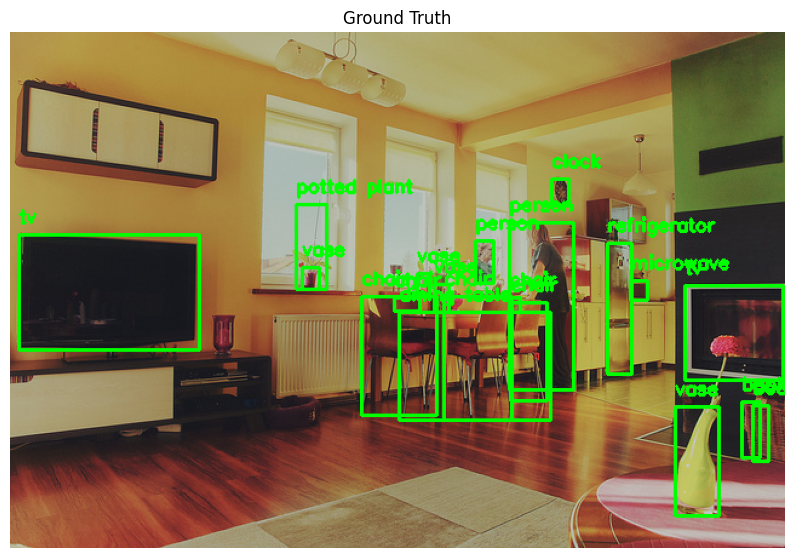

In [88]:
# --- VISUALIZAR GROUND TRUTH ---

# Cargar anotaciones COCO
coco = COCO(ANNOTATIONS_FILE)
gt_boxes, gt_classes = get_ground_truth(coco, IMAGE_ID)

# Visualizar Ground Truth inicial
img_gt = cv2.imread((str(IMAGE_PATH)))
img_gt_viz = draw_boxes(img_gt.copy(), gt_boxes, gt_classes, GREEN) # Verde para GT
cv2.imwrite(os.path.join(OUTPUT_DIR, "ground_truth_only.jpg"), img_gt_viz)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_gt_viz, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Ground Truth")
plt.show()


In [89]:
# 2. Benchmark de modelos YOLO
model_variants = ['n', 's', 'm', 'l', 'x']
results_data = []
all_predictions = {}


for var in model_variants:
    model_name = f'yolov8{var}.pt'
    model = YOLO(model_name)
    results = model(IMAGE_PATH, verbose=False)[0]
  
    pred_boxes = results.boxes.xyxy.cpu().numpy()
    pred_conf = results.boxes.conf.cpu().numpy()
    pred_classes = [results.names[int(c)] for c in results.boxes.cls.cpu().numpy()]
    
    all_predictions[var] = {
        'boxes': pred_boxes,
        'classes': pred_classes,
        'conf': pred_conf
    }
    
    # Calcular métricas simples para esta imagen (IoU > 0.5)
    tp = 0
    matched_gt = set()
    for p_box in pred_boxes:
        for i, g_box in enumerate(gt_boxes):
            if i not in matched_gt and calculate_iou(p_box, g_box) > 0.5:
                tp += 1
                matched_gt.add(i)
                break
    
    precision = tp / len(pred_boxes) if len(pred_boxes) > 0 else 0
    recall = tp / len(gt_boxes) if len(gt_boxes) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    results_data.append({
        "Modelo": model_name,
        "Detecciones": len(pred_boxes),
        "Conf_Media": np.mean(pred_conf) if len(pred_conf) > 0 else 0,
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3),
        "Tiempo_Inferencia(ms)": round(results.speed['inference'], 3)
    })

In [90]:
df = pd.DataFrame(results_data)
print("\nComparativa de modelos YOLO (Imagen 139)")
print(df)

df.to_csv(OUTPUT_DIR / "yolo_model_comparison.csv", index=False)


Comparativa de modelos YOLO (Imagen 139)
       Modelo  Detecciones  Conf_Media  Precision  Recall  F1-Score  \
0  yolov8n.pt           13    0.483737      0.615     0.4     0.485   
1  yolov8s.pt           16    0.581660      0.750     0.6     0.667   
2  yolov8m.pt           20    0.604500      0.600     0.6     0.600   
3  yolov8l.pt           19    0.620313      0.737     0.7     0.718   
4  yolov8x.pt           19    0.630486      0.737     0.7     0.718   

   Tiempo_Inferencia(ms)  
0                 47.849  
1                100.140  
2                219.036  
3                392.338  
4                560.833  


In [91]:
# Nos quedamos con el modelo con más detecciones
best_var = df.loc[df['Detecciones'].idxmax()]['Modelo'].split('v8')[1].split('.')[0]
best_preds = all_predictions[best_var]
print(f"\nMejor modelo seleccionado: YOLOv8{best_var}")


Mejor modelo seleccionado: YOLOv8m


Resultado visual guardado en: c:\Users\carlo\Desktop\practicas-aprendizaje\profundo\results\final_comparison_yolov8m.jpg


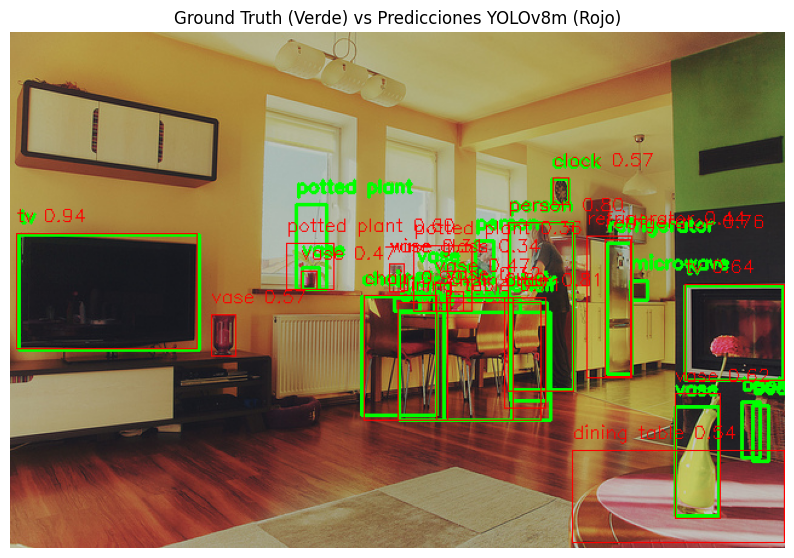

In [92]:
# 5. Visualización Final (GT vs Preds)
final_viz = cv2.imread((str(IMAGE_PATH)))

# Dibujar Ground Truth en Verde
final_viz = draw_boxes(final_viz, gt_boxes, gt_classes, GREEN, 2)

# Dibujar Predicciones en Rojo
pred_labels = [f"{c} {conf:.2f}" for c, conf in zip(best_preds['classes'], best_preds['conf'])]
final_viz = draw_boxes(final_viz, best_preds['boxes'], pred_labels, RED, 1)

# Guardar resultado
output_path = os.path.join(OUTPUT_DIR, f"final_comparison_yolov8{best_var}.jpg")
cv2.imwrite(output_path, final_viz)
print(f"Resultado visual guardado en: {output_path}")

# Mostrar resultado
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(final_viz, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Ground Truth (Verde) vs Predicciones YOLOv8{best_var} (Rojo)")
plt.show()